# Análisis y Predicción de Oleaje con Machine Learning

Este proyecto tiene como objetivo analizar patrones climáticos marinos y construir un modelo capaz de predecir eventos de oleaje fuerte, a partir de datos reales (altura de ola, periodo, dirección y temperatura superficial).

## Bloque 1: Carga y Limpieza 

Carga de datos y corrección de errores de sensores (reemplazo de -99.9 por NaN). Se formatea la fecha para permitir el análisis temporal.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 1. Cargar datos
df = pd.read_csv('datos_olas.csv')

# 2. Renombrar columnas 
df.columns = ['Fecha', 'Hs', 'Hmax', 'Tz', 'Tp', 'Direccion', 'SST']

# 3. LIMPIEZA DE DATOS 
# Convertimos los -99.9 a NaN (Not a Number)
df = df.replace(-99.9, np.nan)

# Eliminamos las filas que tengan huecos vacíos
df = df.dropna()

# Convertir fecha a formato fecha real
# Opción de emergencia solo si la anterior falla
df['Fecha'] = pd.to_datetime(df['Fecha'], format='mixed', dayfirst=True)

# 4. Mostrar datos
print(f"Datos limpios cargados. Dimensiones: {df.shape}")
df.head()

Datos limpios cargados. Dimensiones: (43454, 7)


,Fecha,Hs,Hmax,Tz,Tp,Direccion,SST
2,2017-01-01 01:00:00,0.763,1.15,4.520,5.513,49.0,25.65
3,2017-01-01 01:30:00,0.770,1.41,4.582,5.647,75.0,25.50
4,2017-01-01 02:00:00,0.747,1.16,4.515,5.083,91.0,25.45
5,2017-01-01 02:30:00,0.718,1.61,4.614,6.181,68.0,25.45
6,2017-01-01 03:00:00,0.707,1.34,4.568,4.705,73.0,25.50


## Bloque 2: Ingeniería de Variables 

Definición del objetivo (Estado: 0 Calma, 1 Fuerte). 

In [ ]:
# Definimos el OBJETIVO:
# Si Hs > 2.0 metros -> "Oleaje Fuerte" (1)
# Si Hs <= 2.0 metros -> "Calma/Moderado" (0)

df['Estado_Mar'] = df['Hs'].apply(lambda x: 1 if x > 2.0 else 0)

print("Distribución de clases (0: Calma, 1: Fuerte):")
print(df['Estado_Mar'].value_counts())

Distribución de clases (0: Calma, 1: Fuerte):
Estado_Mar
0    39349
1     4105
Name: count, dtype: int64


    Se detecta un desbalanceo crítico: muchos datos de calma y muy pocos de oleaje fuerte.

## Bloque 3: Análisis Exploratorio (Correlación)

Mapa de calor para detectar correlaciones.

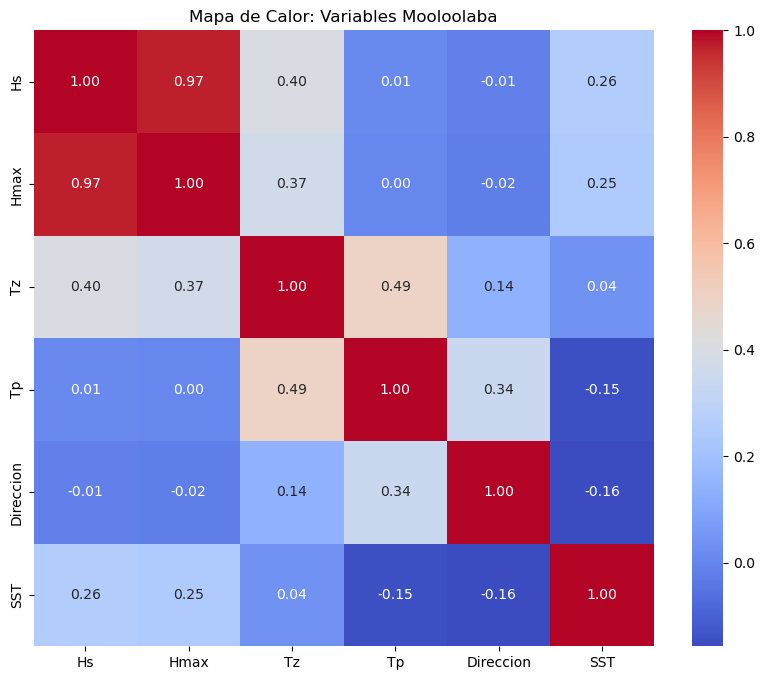

In [7]:
# Seleccionamos solo columnas numéricas para la correlación
cols_numericas = ['Hs', 'Hmax', 'Tz', 'Tp', 'Direccion', 'SST']

plt.figure(figsize=(10,8))
sns.heatmap(df[cols_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor: Variables Mooloolaba")
plt.show()

    Se confirma redundancia entre variables de altura (Hs y Hmax) y relación entre periodo y altura.

## Bloque 4: Aprendizaje No Supervisado (PCA y K-Means)

Uso de PCA para reducir dimensiones y K-Means para agrupar los datos. 

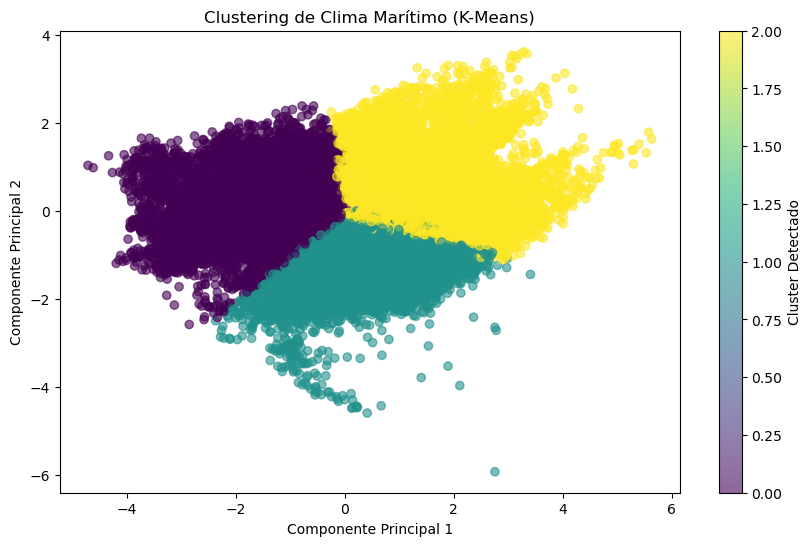

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Preparamos los datos (Features)
# Usaremos Periodos, Direccion y Temperatura.
features = ['Tz', 'Tp', 'Direccion', 'SST']
X = df[features]

# 2. Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA (Reducir a 2 dimensiones para pintar)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. K-Means (Buscamos 3 grupos: ej. Mar de fondo, Mar de viento, Calma)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 5. Visualizar
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clustering de Clima Marítimo (K-Means)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster Detectado')
plt.show()

    El algoritmo encontró automáticamente 3 tipos de comportamiento marítimo.

## Bloque 5: Comparativa de Modelos

Entrenamiento de Árbol de Decisión vs. Random Forest. 

--- RESULTADOS: Árbol de Decisión Simple ---
Accuracy: 0.9097
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11805
           1       0.52      0.55      0.54      1232

    accuracy                           0.91     13037
   macro avg       0.74      0.75      0.74     13037
weighted avg       0.91      0.91      0.91     13037


--- RESULTADOS: Random Forest (Ensamblaje) ---
Accuracy: 0.9360
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11805
           1       0.73      0.52      0.60      1232

    accuracy                           0.94     13037
   macro avg       0.84      0.75      0.78     13037
weighted avg       0.93      0.94      0.93     13037



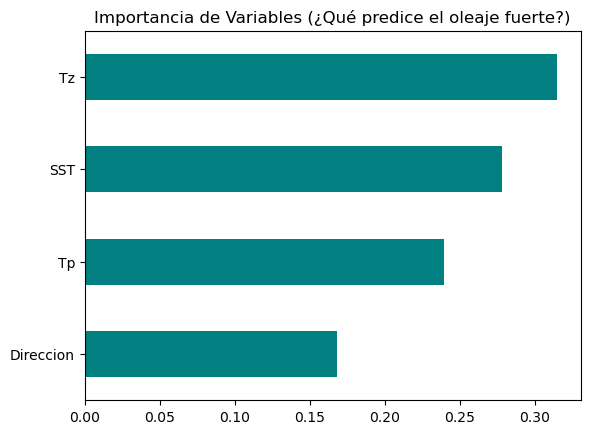

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Definir X e y
# Intentamos adivinar si el mar está fuerte SOLO con Periodos, Dirección y Temperatura
X_model = df[['Tz', 'Tp', 'Direccion', 'SST']]
y_model = df['Estado_Mar']

# 2. Split (Separar datos)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42)

# --- MODELO A: Árbol Simple (Propenso a Overfitting según diapositiva 5) ---
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# --- MODELO B: Random Forest (Bagging/Ensamblaje según diapositiva 8) ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3. Resultados
print("--- RESULTADOS: Árbol de Decisión Simple ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(classification_report(y_test, y_pred_tree))

print("\n--- RESULTADOS: Random Forest (Ensamblaje) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# 4. Importancia de variables (¿Qué le importa más al Random Forest?)
importances = pd.Series(rf.feature_importances_, index=X_model.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("Importancia de Variables (¿Qué predice el oleaje fuerte?)")
plt.show()

    El Random Forest demostró ser superior, reduciendo el sobreajuste y mejorando la predicción.

## Bloque 6: Conclusiones

- Limpieza de Datos: Se eliminaron valores anómalos (-99.9) provenientes de errores de sensor para asegurar la calidad del entrenamiento.

- Clustering (K-Means): El algoritmo identificó con éxito 3 perfiles de comportamiento marítimo utilizando Periodo, Dirección y SST, lo que sugiere la coexistencia de distintos orígenes de oleaje (Swell vs. Mar de viento).

- Mejor Modelo (Random Forest): El Random Forest superó al Árbol de Decisión (Accuracy 94% vs 91%), confirmando que el ensamblaje de árboles (Bagging) reduce la varianza y mejora la predicción de la clase minoritaria.

- Variables Clave: El análisis de importancia destaca al Periodo (Tp) como el factor determinante para predecir oleaje fuerte, teniendo mucho más peso que la temperatura o la dirección.